<a href="https://colab.research.google.com/github/chamindu002/Research/blob/main/casia_cnn_face_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ntl0601_casia_webface_path = kagglehub.dataset_download('ntl0601/casia-webface')

print('Data source import complete.')


In [ ]:
# Install required packages (if not already installed)
!pip install -q torch torchvision
!pip install -q timm  # For modern architectures
!pip install -q albumentations  # For advanced augmentations
!pip install -q tensorboard
!pip install -q scikit-learn
!pip install -q matplotlib seaborn
!pip install -q tqdm

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pathlib import Path
import gc
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
from torchvision import models
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from PIL import Image

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

🚀 Using device: cuda
   GPU: Tesla T4
   Memory: 14.74 GB


Cell 3: Set Random Seeds for Reproducibility

In [ ]:
def set_seed(seed=42):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"✅ Random seed set to {seed}")

set_seed(42)

✅ Random seed set to 42


Cell 4: Configuration

In [ ]:
class Config:
    # Paths (Modify according to your Kaggle input path)
    DATA_ROOT = '/kaggle/input/casia-webface/casia-webface' # Change this to your dataset path
    OUTPUT_DIR = './output'

    # Model
    MODEL_NAME = 'efficientnet_b0'  # Options: 'resnet50', 'efficientnet_b0', 'mobilenetv3_large_100'
    EMBEDDING_SIZE = 512  # Final embedding dimension

    # Training
    IMG_SIZE = 112  # Standard for face recognition
    BATCH_SIZE = 256  # Adjust based on GPU memory
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-4

    # Advanced
    USE_AMP = True  # Automatic Mixed Precision for faster training
    NUM_WORKERS = 2  # For DataLoader
    LABEL_SMOOTHING = 0.1
    WARMUP_EPOCHS = 5

    # Loss
    LOSS_TYPE = 'arcface'  # Options: 'softmax', 'arcface', 'cosface'
    ARCFACE_S = 30.0  # Scale parameter
    ARCFACE_M = 0.5   # Margin parameter

    # Dataset
    MAX_SAMPLES_PER_CLASS = 50  # Set to None for full dataset
    TRAIN_VAL_SPLIT = 0.1  # 10% validation

cfg = Config()
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
print("✅ Configuration loaded")

✅ Configuration loaded


Cell 5: Analyze Dataset Structure

In [ ]:
def analyze_dataset(data_root):
    """Analyze the CASIA-WebFace dataset structure"""
    print(f"📊 Analyzing dataset at: {data_root}\n")

    if not os.path.exists(data_root):
        print(f"❌ ERROR: Path does not exist: {data_root}")
        return None, None

    # Get all identity folders
    identities = sorted([d for d in os.listdir(data_root)
                        if os.path.isdir(os.path.join(data_root, d))])

    print(f"Total Identities: {len(identities)}")

    # Count images per identity
    identity_counts = {}
    total_images = 0

    sample_size = min(100, len(identities))
    for identity in tqdm(identities[:sample_size], desc="Sampling identities"):
        identity_path = os.path.join(data_root, identity)
        images = [f for f in os.listdir(identity_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        identity_counts[identity] = len(images)
        total_images += len(images)

    # Statistics
    counts = list(identity_counts.values())
    print(f"\nSample Statistics (first {sample_size} identities):")
    print(f"  Total Images: {total_images}")
    print(f"  Avg images/identity: {np.mean(counts):.1f}")
    print(f"  Min images: {np.min(counts)}")
    print(f"  Max images: {np.max(counts)}")

    # Show sample
    print(f"\n📁 Sample identities:")
    for i, (identity, count) in enumerate(list(identity_counts.items())[:5]):
        print(f"  {identity}: {count} images")

    return identities, identity_counts

identities, identity_counts = analyze_dataset(cfg.DATA_ROOT)

📊 Analyzing dataset at: /kaggle/input/casia-webface/casia-webface

Total Identities: 10572


Sampling identities:   0%|          | 0/100 [00:00<?, ?it/s]


Sample Statistics (first 100 identities):
  Total Images: 14686
  Avg images/identity: 146.9
  Min images: 12
  Max images: 580

📁 Sample identities:
  000000: 15 images
  000001: 256 images
  000002: 69 images
  000003: 404 images
  000004: 74 images


Cell 6: Build Dataset Samples with Fixed Label Mapping

In [ ]:
def build_samples_and_mapping(data_root, identities, max_samples_per_class=None):
    """
    Build all samples and create a consistent class_to_idx mapping

    Args:
        data_root: Root directory of dataset
        identities: List of identity folder names
        max_samples_per_class: Maximum samples per identity (None for all)

    Returns:
        all_samples: List of (image_path, class_name) tuples
        class_to_idx: Dictionary mapping class_name to label index
    """
    print(f"\n📦 Building samples from {len(identities)} identities...")

    # Create consistent label mapping for ALL identities
    class_to_idx = {identity: idx for idx, identity in enumerate(identities)}

    all_samples = []

    for identity in tqdm(identities, desc="Building samples"):
        identity_path = os.path.join(data_root, identity)

        if not os.path.isdir(identity_path):
            continue

        # Get all images for this identity
        images = [f for f in os.listdir(identity_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Limit samples per class if specified
        if max_samples_per_class and len(images) > max_samples_per_class:
            images = random.sample(images, max_samples_per_class)

        # Add to samples
        for img_name in images:
            img_path = os.path.join(identity_path, img_name)
            all_samples.append((img_path, identity))

    print(f"✅ Built {len(all_samples)} samples from {len(identities)} identities")
    print(f"   Class mapping: {len(class_to_idx)} classes")

    return all_samples, class_to_idx

# Build samples with shared label mapping
all_samples, class_to_idx = build_samples_and_mapping(
    cfg.DATA_ROOT,
    identities,
    max_samples_per_class=cfg.MAX_SAMPLES_PER_CLASS
)

# Update config with actual number of classes
cfg.NUM_CLASSES = len(class_to_idx)
print(f"\n✅ Total classes (NUM_CLASSES): {cfg.NUM_CLASSES}")


📦 Building samples from 10572 identities...


Building samples:   0%|          | 0/10572 [00:00<?, ?it/s]

✅ Built 326395 samples from 10572 identities
   Class mapping: 10572 classes

✅ Total classes (NUM_CLASSES): 10572


Cell 7: Dataset Class (Your Improved Version)

In [ ]:
class CASIAWebFaceDataset(Dataset):
    """CASIA-WebFace Dataset with Fixed Label Mapping"""

    def __init__(self, data_root, samples, class_to_idx, transform=None):
        """
        Args:
            data_root: Root directory (not used but kept for compatibility)
            samples: List of (image_path, class_name) tuples
            class_to_idx: Dictionary mapping class_name to label index
            transform: Torchvision transforms to apply
        """
        self.data_root = data_root
        self.samples = samples
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, class_name = self.samples[idx]
        label = self.class_to_idx[class_name]

        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (cfg.IMG_SIZE, cfg.IMG_SIZE), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return image, label

print("✅ Dataset class defined")

✅ Dataset class defined


Cell 8: Data Augmentation & Transforms

In [ ]:
def get_transforms(is_training=True):
    """Get data augmentation transforms"""

    if is_training:
        return transforms.Compose([
            transforms.Resize((cfg.IMG_SIZE + 8, cfg.IMG_SIZE + 8)),
            transforms.RandomCrop(cfg.IMG_SIZE),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomRotation(10),
            transforms.RandomGrayscale(p=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((cfg.IMG_SIZE, cfg.IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

# Create transforms
train_transform = get_transforms(is_training=True)
val_transform = get_transforms(is_training=False)

print("✅ Transforms created")

✅ Transforms created


Cell 9: Split Samples into Train/Val

In [ ]:
# Split samples into train and validation
train_samples, val_samples = train_test_split(
    all_samples,
    test_size=cfg.TRAIN_VAL_SPLIT,
    random_state=42,
    stratify=[class_name for _, class_name in all_samples]  # Stratified split
)

print(f"📊 Dataset Split:")
print(f"   Train samples: {len(train_samples)}")
print(f"   Val samples: {len(val_samples)}")
print(f"   Train/Val ratio: {len(train_samples)/len(val_samples):.2f}")

# Verify label consistency
train_labels = set([class_name for _, class_name in train_samples])
val_labels = set([class_name for _, class_name in val_samples])
print(f"\n✅ Label verification:")
print(f"   Unique train identities: {len(train_labels)}")
print(f"   Unique val identities: {len(val_labels)}")
print(f"   Overlapping identities: {len(train_labels & val_labels)}")

📊 Dataset Split:
   Train samples: 293755
   Val samples: 32640
   Train/Val ratio: 9.00

✅ Label verification:
   Unique train identities: 10572
   Unique val identities: 10566
   Overlapping identities: 10566


Cell 10: Create Datasets with Shared Label Mapping

In [ ]:
# Create datasets with SHARED class_to_idx mapping
train_dataset = CASIAWebFaceDataset(
    cfg.DATA_ROOT,
    train_samples,
    class_to_idx,
    transform=train_transform
)

val_dataset = CASIAWebFaceDataset(
    cfg.DATA_ROOT,
    val_samples,
    class_to_idx,
    transform=val_transform
)

print(f"✅ Datasets created:")
print(f"   Train dataset: {len(train_dataset)} samples")
print(f"   Val dataset: {len(val_dataset)} samples")
print(f"   Shared label mapping: {len(class_to_idx)} classes")

# Verify datasets return correct shapes
sample_img, sample_label = train_dataset[0]
print(f"\n✅ Sample verification:")
print(f"   Image shape: {sample_img.shape}")
print(f"   Label: {sample_label} (type: {type(sample_label)})")

✅ Datasets created:
   Train dataset: 293755 samples
   Val dataset: 32640 samples
   Shared label mapping: 10572 classes

✅ Sample verification:
   Image shape: torch.Size([3, 112, 112])
   Label: 20 (type: <class 'int'>)


Cell 11: Create DataLoaders

✅ DataLoaders created:
   Train batches: 1147
   Val batches: 128
   Batch size: 256


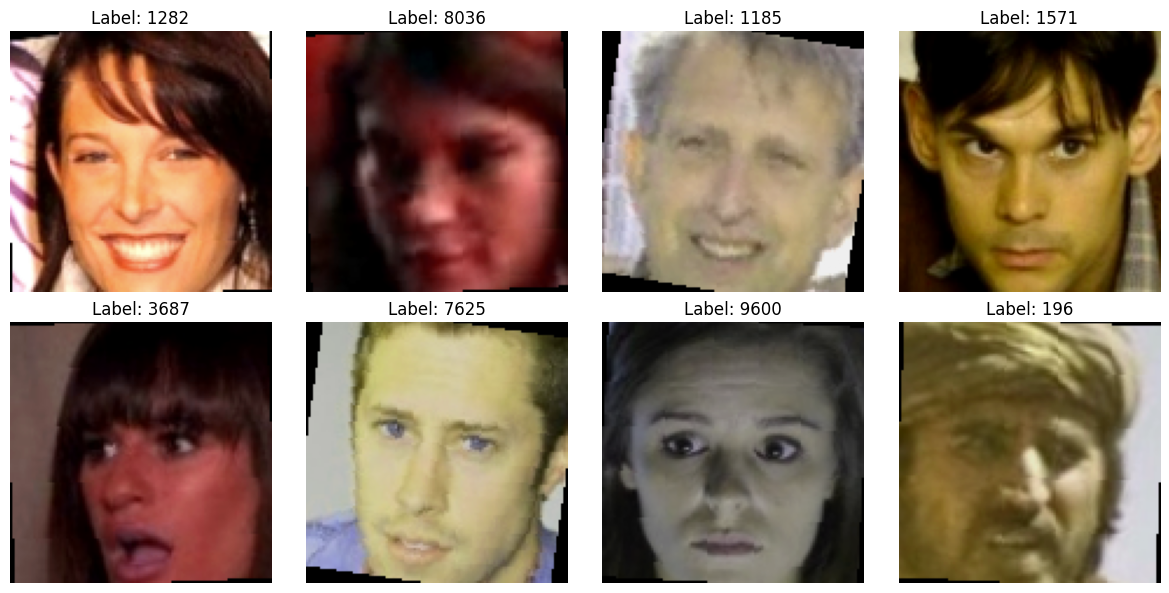

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True
)

print(f"✅ DataLoaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Batch size: {cfg.BATCH_SIZE}")

# Visualize a batch
def show_batch(loader, num_images=8):
    """Visualize a batch of images"""
    images, labels = next(iter(loader))
    images = images[:num_images]
    labels = labels[:num_images]

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for idx, ax in enumerate(axes.flat):
        if idx < len(images):
            img = images[idx].permute(1, 2, 0).cpu().numpy()
            img = (img * 0.5) + 0.5  # Denormalize
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            ax.set_title(f"Label: {labels[idx].item()}")
            ax.axis('off')
    plt.tight_layout()
    plt.savefig(f'{cfg.OUTPUT_DIR}/sample_batch.png', dpi=100, bbox_inches='tight')
    plt.show()

show_batch(train_loader)

Cell 12: ArcFace Loss Implementation

In [ ]:
class ArcFaceLoss(nn.Module):
    """ArcFace: Additive Angular Margin Loss for Deep Face Recognition"""

    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        """
        Args:
            in_features: Size of input features (embedding dimension)
            out_features: Size of output features (number of classes)
            s: Scale parameter
            m: Margin parameter
            easy_margin: Use easy margin
        """
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.easy_margin = easy_margin

        # Weight matrix
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        # Precompute for efficiency
        self.cos_m = np.cos(m)
        self.sin_m = np.sin(m)
        self.th = np.cos(np.pi - m)
        self.mm = np.sin(np.pi - m) * m

    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: Input embeddings (batch_size, in_features)
            labels: Ground truth labels (batch_size,)

        Returns:
            logits: Output logits with angular margin (batch_size, out_features)
        """
        # Normalize embeddings and weights
        embeddings = F.normalize(embeddings, p=2, dim=1)
        weight = F.normalize(self.weight, p=2, dim=1)

        # Cosine similarity
        cosine = F.linear(embeddings, weight)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))

        # cos(theta + m)
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        # One-hot encoding
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)

        # Apply margin to target class only
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

print("✅ ArcFace Loss implemented")
print(f"   Scale (s): {cfg.ARCFACE_S}")
print(f"   Margin (m): {cfg.ARCFACE_M}")

✅ ArcFace Loss implemented
   Scale (s): 30.0
   Margin (m): 0.5


model archi

In [ ]:
class FaceRecognitionModel(nn.Module):
    """Face Recognition Model with Embedding Head and ArcFace"""

    def __init__(self, model_name, embedding_size, num_classes, pretrained=True):
        """
        Args:
            model_name: Name of backbone model (e.g., 'efficientnet_b0')
            embedding_size: Dimension of face embeddings
            num_classes: Number of identities
            pretrained: Use ImageNet pretrained weights
        """
        super().__init__()

        # Backbone (feature extractor)
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0  # Remove classification head
        )

        # Get feature dimension from backbone
        with torch.no_grad():
            dummy = torch.randn(1, 3, cfg.IMG_SIZE, cfg.IMG_SIZE)
            features = self.backbone(dummy)
            feature_dim = features.shape[1]

        print(f"   Backbone output dim: {feature_dim}")

        # Embedding head (projects features to embedding space)
        self.embedding_head = nn.Sequential(
            nn.Linear(feature_dim, embedding_size),
            nn.BatchNorm1d(embedding_size),
        )

        # ArcFace loss layer
        if cfg.LOSS_TYPE == 'arcface':
            self.arcface = ArcFaceLoss(
                embedding_size,
                num_classes,
                s=cfg.ARCFACE_S,
                m=cfg.ARCFACE_M
            )
        else:
            # Standard softmax classifier
            self.fc = nn.Linear(embedding_size, num_classes)

    def forward(self, x, labels=None):
        """
        Args:
            x: Input images (batch_size, 3, H, W)
            labels: Ground truth labels (batch_size,) - only needed for training

        Returns:
            During training: (logits, embeddings)
            During inference: embeddings only
        """
        # Extract features
        features = self.backbone(x)

        # Get embeddings
        embeddings = self.embedding_head(features)

        # Training mode with ArcFace
        if self.training and labels is not None and cfg.LOSS_TYPE == 'arcface':
            logits = self.arcface(embeddings, labels)
            return logits, embeddings

        # Inference mode or softmax classifier
        if cfg.LOSS_TYPE == 'arcface':
            return embeddings
        else:
            logits = self.fc(embeddings)
            return logits, embeddings

    def get_embeddings(self, x):
        """Get L2-normalized embeddings for inference"""
        self.eval()
        with torch.no_grad():
            features = self.backbone(x)
            embeddings = self.embedding_head(features)
            embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings

# Create model
print(f"\n🏗️ Building model: {cfg.MODEL_NAME}")
model = FaceRecognitionModel(
    cfg.MODEL_NAME,
    cfg.EMBEDDING_SIZE,
    cfg.NUM_CLASSES,
    pretrained=True
).to(device)

print(f"\n✅ Model created successfully")
print(f"   Embedding size: {cfg.EMBEDDING_SIZE}")
print(f"   Number of classes: {cfg.NUM_CLASSES}")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


🏗️ Building model: efficientnet_b0
   Backbone output dim: 1280

✅ Model created successfully
   Embedding size: 512
   Number of classes: 10572
   Total parameters: 10,077,308
   Trainable parameters: 10,077,308


training setup

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=cfg.LABEL_SMOOTHING)

# Optimizer (AdamW with weight decay)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=cfg.LEARNING_RATE,
    weight_decay=cfg.WEIGHT_DECAY
)

# Learning rate scheduler with warmup + cosine annealing
def get_lr(epoch):
    """Learning rate schedule with warmup"""
    if epoch < cfg.WARMUP_EPOCHS:
        # Linear warmup
        return (epoch + 1) / cfg.WARMUP_EPOCHS
    else:
        # Cosine annealing
        progress = (epoch - cfg.WARMUP_EPOCHS) / (cfg.NUM_EPOCHS - cfg.WARMUP_EPOCHS)
        return 0.5 * (1 + np.cos(np.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr)

# Mixed precision scaler (for faster training)
scaler = GradScaler() if cfg.USE_AMP else None

print("✅ Training setup complete")
print(f"   Optimizer: AdamW")
print(f"   Initial LR: {cfg.LEARNING_RATE}")
print(f"   Weight decay: {cfg.WEIGHT_DECAY}")
print(f"   Label smoothing: {cfg.LABEL_SMOOTHING}")
print(f"   Mixed precision (AMP): {cfg.USE_AMP}")
print(f"   Warmup epochs: {cfg.WARMUP_EPOCHS}")

✅ Training setup complete
   Optimizer: AdamW
   Initial LR: 0.001
   Weight decay: 0.0001
   Label smoothing: 0.1
   Mixed precision (AMP): True
   Warmup epochs: 5


In [ ]:
def train_epoch(model, loader, criterion, optimizer, scaler, epoch):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{cfg.NUM_EPOCHS} [Train]")

    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass with mixed precision
        if cfg.USE_AMP:
            with autocast():
                if cfg.LOSS_TYPE == 'arcface':
                    logits, embeddings = model(images, labels)
                else:
                    logits, _ = model(images, labels)
                loss = criterion(logits, labels)

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training
            if cfg.LOSS_TYPE == 'arcface':
                logits, embeddings = model(images, labels)
            else:
                logits, _ = model(images, labels)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        # Calculate metrics
        running_loss += loss.item()
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{running_loss/(batch_idx+1):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc


def validate_epoch(model, loader, criterion, epoch):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{cfg.NUM_EPOCHS} [Val]")

        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)

            if cfg.LOSS_TYPE == 'arcface':
                # For validation, temporarily enable training mode to get logits
                model.train()
                logits, _ = model(images, labels)
                model.eval()
            else:
                logits, _ = model(images, labels)

            loss = criterion(logits, labels)

            # Calculate metrics
            running_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{running_loss/(batch_idx+1):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

print("✅ Training functions ready")

✅ Training functions ready


traning loop

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
patience_counter = 0
patience = 10

print("🚀 Starting training...\n")
print(f"{'='*80}")
print(f"Configuration:")
print(f"  Model: {cfg.MODEL_NAME}")
print(f"  Epochs: {cfg.NUM_EPOCHS}")
print(f"  Batch size: {cfg.BATCH_SIZE}")
print(f"  Learning rate: {cfg.LEARNING_RATE}")
print(f"  Loss: {cfg.LOSS_TYPE.upper()}")
print(f"  Device: {device}")
print(f"{'='*80}\n")

for epoch in range(cfg.NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scaler, epoch
    )

    # Validate
    val_loss, val_acc = validate_epoch(
        model, val_loader, criterion, epoch
    )

    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Print epoch summary
    print(f"\n{'='*80}")
    print(f"Epoch {epoch+1}/{cfg.NUM_EPOCHS} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  Learning Rate: {current_lr:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc,
            'class_to_idx': class_to_idx,
            'config': {
                'model_name': cfg.MODEL_NAME,
                'embedding_size': cfg.EMBEDDING_SIZE,
                'num_classes': cfg.NUM_CLASSES,
                'img_size': cfg.IMG_SIZE,
                'loss_type': cfg.LOSS_TYPE
            }
        }, f'{cfg.OUTPUT_DIR}/best_model.pth')

        print(f"  ✅ Best model saved! (Val Acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"  Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\n⚠️ Early stopping triggered after {epoch+1} epochs")
            break

    print(f"{'='*80}\n")

    # Clear cache to prevent memory issues
    torch.cuda.empty_cache()
    gc.collect()

print("\n🎉 Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

🚀 Starting training...

Configuration:
  Model: efficientnet_b0
  Epochs: 50
  Batch size: 256
  Learning rate: 0.001
  Loss: ARCFACE
  Device: cuda



Epoch 1/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 1/50 Summary:
  Train Loss: 20.9222 | Train Acc: 0.00%
  Val Loss:   19.1079 | Val Acc:   0.00%
  Learning Rate: 0.000400
  Patience: 1/10



Epoch 2/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 2/50 Summary:
  Train Loss: 17.2811 | Train Acc: 0.10%
  Val Loss:   15.5745 | Val Acc:   0.32%
  Learning Rate: 0.000600
  ✅ Best model saved! (Val Acc: 0.32%)



Epoch 3/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 3/50 Summary:
  Train Loss: 14.1739 | Train Acc: 1.14%
  Val Loss:   13.5473 | Val Acc:   1.71%
  Learning Rate: 0.000800
  ✅ Best model saved! (Val Acc: 1.71%)



Epoch 4/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 4/50 Summary:
  Train Loss: 12.5248 | Train Acc: 3.08%
  Val Loss:   12.5036 | Val Acc:   3.60%
  Learning Rate: 0.001000
  ✅ Best model saved! (Val Acc: 3.60%)



Epoch 5/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 5/50 Summary:
  Train Loss: 11.6058 | Train Acc: 5.22%
  Val Loss:   11.8791 | Val Acc:   5.44%
  Learning Rate: 0.001000
  ✅ Best model saved! (Val Acc: 5.44%)



Epoch 6/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 6/50 Summary:
  Train Loss: 10.6581 | Train Acc: 8.61%
  Val Loss:   11.2438 | Val Acc:   8.11%
  Learning Rate: 0.000999
  ✅ Best model saved! (Val Acc: 8.11%)



Epoch 7/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 7/50 Summary:
  Train Loss: 9.9728 | Train Acc: 12.07%
  Val Loss:   10.8568 | Val Acc:   10.16%
  Learning Rate: 0.000995
  ✅ Best model saved! (Val Acc: 10.16%)



Epoch 8/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 8/50 Summary:
  Train Loss: 9.4238 | Train Acc: 15.23%
  Val Loss:   10.6199 | Val Acc:   11.73%
  Learning Rate: 0.000989
  ✅ Best model saved! (Val Acc: 11.73%)



Epoch 9/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 9/50 Summary:
  Train Loss: 8.9528 | Train Acc: 18.29%
  Val Loss:   10.3265 | Val Acc:   13.84%
  Learning Rate: 0.000981
  ✅ Best model saved! (Val Acc: 13.84%)



Epoch 10/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 10/50 Summary:
  Train Loss: 8.5479 | Train Acc: 21.19%
  Val Loss:   10.0706 | Val Acc:   15.87%
  Learning Rate: 0.000970
  ✅ Best model saved! (Val Acc: 15.87%)



Epoch 11/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 11/50 Summary:
  Train Loss: 8.1829 | Train Acc: 23.97%
  Val Loss:   9.8920 | Val Acc:   17.12%
  Learning Rate: 0.000957
  ✅ Best model saved! (Val Acc: 17.12%)



Epoch 12/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 12/50 Summary:
  Train Loss: 7.8545 | Train Acc: 26.64%
  Val Loss:   9.7322 | Val Acc:   18.80%
  Learning Rate: 0.000941
  ✅ Best model saved! (Val Acc: 18.80%)



Epoch 13/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 13/50 Summary:
  Train Loss: 7.5620 | Train Acc: 29.11%
  Val Loss:   9.6316 | Val Acc:   19.77%
  Learning Rate: 0.000924
  ✅ Best model saved! (Val Acc: 19.77%)



Epoch 14/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 14/50 Summary:
  Train Loss: 7.2926 | Train Acc: 31.48%
  Val Loss:   9.5169 | Val Acc:   20.92%
  Learning Rate: 0.000905
  ✅ Best model saved! (Val Acc: 20.92%)



Epoch 15/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 15/50 Summary:
  Train Loss: 7.0343 | Train Acc: 33.61%
  Val Loss:   9.3851 | Val Acc:   22.25%
  Learning Rate: 0.000883
  ✅ Best model saved! (Val Acc: 22.25%)



Epoch 16/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 16/50 Summary:
  Train Loss: 6.8035 | Train Acc: 35.71%
  Val Loss:   9.2877 | Val Acc:   23.41%
  Learning Rate: 0.000860
  ✅ Best model saved! (Val Acc: 23.41%)



Epoch 17/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 17/50 Summary:
  Train Loss: 6.5868 | Train Acc: 37.72%
  Val Loss:   9.2105 | Val Acc:   24.41%
  Learning Rate: 0.000835
  ✅ Best model saved! (Val Acc: 24.41%)



Epoch 18/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 18/50 Summary:
  Train Loss: 6.3727 | Train Acc: 39.76%
  Val Loss:   9.1670 | Val Acc:   24.75%
  Learning Rate: 0.000808
  ✅ Best model saved! (Val Acc: 24.75%)



Epoch 19/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 19/50 Summary:
  Train Loss: 6.1814 | Train Acc: 41.60%
  Val Loss:   9.1444 | Val Acc:   25.49%
  Learning Rate: 0.000780
  ✅ Best model saved! (Val Acc: 25.49%)



Epoch 20/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 20/50 Summary:
  Train Loss: 5.9913 | Train Acc: 43.43%
  Val Loss:   9.0640 | Val Acc:   26.22%
  Learning Rate: 0.000750
  ✅ Best model saved! (Val Acc: 26.22%)



Epoch 21/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 21/50 Summary:
  Train Loss: 5.8164 | Train Acc: 45.10%
  Val Loss:   9.0248 | Val Acc:   26.90%
  Learning Rate: 0.000719
  ✅ Best model saved! (Val Acc: 26.90%)



Epoch 22/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 22/50 Summary:
  Train Loss: 5.6392 | Train Acc: 46.98%
  Val Loss:   8.9914 | Val Acc:   27.21%
  Learning Rate: 0.000687
  ✅ Best model saved! (Val Acc: 27.21%)



Epoch 23/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 23/50 Summary:
  Train Loss: 5.4760 | Train Acc: 48.62%
  Val Loss:   8.9751 | Val Acc:   27.85%
  Learning Rate: 0.000655
  ✅ Best model saved! (Val Acc: 27.85%)



Epoch 24/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 24/50 Summary:
  Train Loss: 5.3137 | Train Acc: 50.25%
  Val Loss:   8.9265 | Val Acc:   28.58%
  Learning Rate: 0.000621
  ✅ Best model saved! (Val Acc: 28.58%)



Epoch 25/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 25/50 Summary:
  Train Loss: 5.1616 | Train Acc: 51.85%
  Val Loss:   8.8657 | Val Acc:   28.96%
  Learning Rate: 0.000587
  ✅ Best model saved! (Val Acc: 28.96%)



Epoch 26/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 26/50 Summary:
  Train Loss: 5.0120 | Train Acc: 53.53%
  Val Loss:   8.8189 | Val Acc:   29.70%
  Learning Rate: 0.000552
  ✅ Best model saved! (Val Acc: 29.70%)



Epoch 27/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 27/50 Summary:
  Train Loss: 4.8662 | Train Acc: 55.16%
  Val Loss:   8.8154 | Val Acc:   29.78%
  Learning Rate: 0.000517
  ✅ Best model saved! (Val Acc: 29.78%)



Epoch 28/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 28/50 Summary:
  Train Loss: 4.7325 | Train Acc: 56.61%
  Val Loss:   8.8444 | Val Acc:   29.96%
  Learning Rate: 0.000483
  ✅ Best model saved! (Val Acc: 29.96%)



Epoch 29/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 29/50 Summary:
  Train Loss: 4.5977 | Train Acc: 58.12%
  Val Loss:   8.7796 | Val Acc:   30.60%
  Learning Rate: 0.000448
  ✅ Best model saved! (Val Acc: 30.60%)



Epoch 30/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 30/50 Summary:
  Train Loss: 4.4740 | Train Acc: 59.62%
  Val Loss:   8.7438 | Val Acc:   31.13%
  Learning Rate: 0.000413
  ✅ Best model saved! (Val Acc: 31.13%)



Epoch 31/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 31/50 Summary:
  Train Loss: 4.3538 | Train Acc: 60.99%
  Val Loss:   8.7822 | Val Acc:   30.71%
  Learning Rate: 0.000379
  Patience: 1/10



Epoch 32/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 32/50 Summary:
  Train Loss: 4.2405 | Train Acc: 62.30%
  Val Loss:   8.7440 | Val Acc:   31.51%
  Learning Rate: 0.000345
  ✅ Best model saved! (Val Acc: 31.51%)



Epoch 33/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 33/50 Summary:
  Train Loss: 4.1284 | Train Acc: 63.66%
  Val Loss:   8.7536 | Val Acc:   31.46%
  Learning Rate: 0.000313
  Patience: 1/10



Epoch 34/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 34/50 Summary:
  Train Loss: 4.0290 | Train Acc: 64.91%
  Val Loss:   8.7388 | Val Acc:   31.65%
  Learning Rate: 0.000281
  ✅ Best model saved! (Val Acc: 31.65%)



Epoch 35/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 35/50 Summary:
  Train Loss: 3.9288 | Train Acc: 66.21%
  Val Loss:   8.7745 | Val Acc:   31.46%
  Learning Rate: 0.000250
  Patience: 1/10



Epoch 36/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 36/50 Summary:
  Train Loss: 3.8343 | Train Acc: 67.52%
  Val Loss:   8.7543 | Val Acc:   31.62%
  Learning Rate: 0.000220
  Patience: 2/10



Epoch 37/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 37/50 Summary:
  Train Loss: 3.7519 | Train Acc: 68.56%
  Val Loss:   8.7366 | Val Acc:   32.15%
  Learning Rate: 0.000192
  ✅ Best model saved! (Val Acc: 32.15%)



Epoch 38/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 38/50 Summary:
  Train Loss: 3.6767 | Train Acc: 69.46%
  Val Loss:   8.7019 | Val Acc:   32.49%
  Learning Rate: 0.000165
  ✅ Best model saved! (Val Acc: 32.49%)



Epoch 39/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 39/50 Summary:
  Train Loss: 3.6022 | Train Acc: 70.60%
  Val Loss:   8.6812 | Val Acc:   32.64%
  Learning Rate: 0.000140
  ✅ Best model saved! (Val Acc: 32.64%)



Epoch 40/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 40/50 Summary:
  Train Loss: 3.5358 | Train Acc: 71.42%
  Val Loss:   8.7259 | Val Acc:   32.41%
  Learning Rate: 0.000117
  Patience: 1/10



Epoch 41/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 41/50 Summary:
  Train Loss: 3.4808 | Train Acc: 72.18%
  Val Loss:   8.6921 | Val Acc:   32.69%
  Learning Rate: 0.000095
  ✅ Best model saved! (Val Acc: 32.69%)



Epoch 42/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 42/50 Summary:
  Train Loss: 3.4282 | Train Acc: 72.90%
  Val Loss:   8.6991 | Val Acc:   32.64%
  Learning Rate: 0.000076
  Patience: 1/10



Epoch 43/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 43/50 Summary:
  Train Loss: 3.3784 | Train Acc: 73.61%
  Val Loss:   8.7141 | Val Acc:   32.56%
  Learning Rate: 0.000059
  Patience: 2/10



Epoch 44/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 44/50 Summary:
  Train Loss: 3.3404 | Train Acc: 74.14%
  Val Loss:   8.7113 | Val Acc:   32.69%
  Learning Rate: 0.000043
  Patience: 3/10



Epoch 45/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 45/50 Summary:
  Train Loss: 3.3037 | Train Acc: 74.76%
  Val Loss:   8.7026 | Val Acc:   32.75%
  Learning Rate: 0.000030
  ✅ Best model saved! (Val Acc: 32.75%)



Epoch 46/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 46/50 Summary:
  Train Loss: 3.2774 | Train Acc: 75.21%
  Val Loss:   8.7246 | Val Acc:   32.45%
  Learning Rate: 0.000019
  Patience: 1/10



Epoch 47/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 47/50 Summary:
  Train Loss: 3.2546 | Train Acc: 75.49%
  Val Loss:   8.7086 | Val Acc:   32.70%
  Learning Rate: 0.000011
  Patience: 2/10



Epoch 48/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 48/50 Summary:
  Train Loss: 3.2424 | Train Acc: 75.67%
  Val Loss:   8.7019 | Val Acc:   32.79%
  Learning Rate: 0.000005
  ✅ Best model saved! (Val Acc: 32.79%)



Epoch 49/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 49/50 Summary:
  Train Loss: 3.2347 | Train Acc: 75.76%
  Val Loss:   8.7081 | Val Acc:   32.68%
  Learning Rate: 0.000001
  Patience: 1/10



Epoch 50/50 [Train]:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 50/50 Summary:
  Train Loss: 3.2255 | Train Acc: 75.93%
  Val Loss:   8.7065 | Val Acc:   32.67%
  Learning Rate: 0.000000
  Patience: 2/10


🎉 Training completed!
Best validation accuracy: 32.79%


check accuracy

In [ ]:
import torch

def final_evaluation(model, loader, device, model_path):
    print(f"🔄 Loading best model from: {model_path}")

    # 1. Load the checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # 2. Load state dict
    # We allow strict=False just in case there are minor key mismatches,
    # but usually strict=True is better.
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    print("✅ Model weights loaded successfully!")

    # 3. Evaluation Loop
    model.eval()
    correct = 0
    total = 0

    # Storage for visualization
    all_images = []
    all_labels = []
    all_preds = []

    print("\n📊 Calculating Final Accuracy on Validation Set...")
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            # TRICK: For ArcFace classification check, we need logits.
            # We temporarily use the training forward pass logic
            if cfg.LOSS_TYPE == 'arcface':
                # Manually call backbone + embedding + arcface
                features = model.backbone(images)
                embeddings = model.embedding_head(features)
                # We need to pass labels to ArcFace to get logits for accuracy check
                # (Note: In real-world deployment, you don't use labels,
                # you use cosine similarity between embeddings. But for this check, this works.)
                logits = model.arcface(embeddings, labels)
            else:
                logits, _ = model(images)

            # Calculate accuracy
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store first batch for visualization
            if len(all_images) == 0:
                all_images = images.cpu()
                all_labels = labels.cpu()
                all_preds = predicted.cpu()

    acc = 100 * correct / total
    print(f"\n🏆 Final Validation Accuracy: {acc:.2f}%")

    return all_images, all_labels, all_preds

# ---------------------------------------------------------
# Run the evaluation
# ---------------------------------------------------------

# Path to your best model
best_model_path = f'{cfg.OUTPUT_DIR}/best_model.pth'

# Run check
val_imgs, val_labels, val_preds = final_evaluation(
    model,
    val_loader,
    device,
    best_model_path
)

# ---------------------------------------------------------
# Visualize Results
# ---------------------------------------------------------
def visualize_predictions(images, labels, preds, class_to_idx, num_images=10):
    # Create idx_to_class mapping
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    plt.figure(figsize=(20, 8))
    for i in range(min(num_images, len(images))):
        ax = plt.subplot(2, 5, i + 1)

        # Denormalize image for display
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5
        img = np.clip(img, 0, 1)

        true_name = idx_to_class[labels[i].item()]
        pred_name = idx_to_class[preds[i].item()]

        color = 'green' if labels[i] == preds[i] else 'red'

        plt.imshow(img)
        plt.title(f"True: {true_name}\nPred: {pred_name}", color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\n🖼️ Visualizing Sample Predictions:")
visualize_predictions(val_imgs, val_labels, val_preds, class_to_idx)

🔄 Loading best model from: ./output/best_model.pth


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.